<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Baseline" data-toc-modified-id="Baseline-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#Добавление-обучающих-признаков" data-toc-modified-id="Добавление-обучающих-признаков-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Добавление обучающих признаков</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Lasso</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

Загрузим данные и посмотрим общую информацию:

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('C:/ya_pr/taxi/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, что временная последовательность нигде не нарушена:

In [5]:
data.index.is_monotonic_increasing

True

Сгруппируем данные по часам:

In [6]:
data = data.resample('1H').sum()

## Анализ

Период охватываемый предоставленными данными:

In [7]:
print(data.index.max())
print(data.index.min())

2018-08-31 23:00:00
2018-03-01 00:00:00


Посмотрим, на тренд и периодичность данных:

In [8]:
decomposed = seasonal_decompose(data['2018-08':'2018-09'])

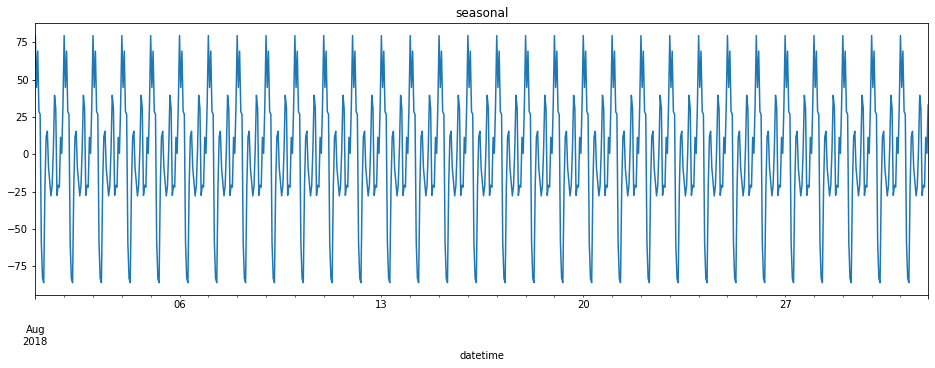

In [9]:
plt.figure(figsize=(16, 5))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('seasonal')
plt.show()

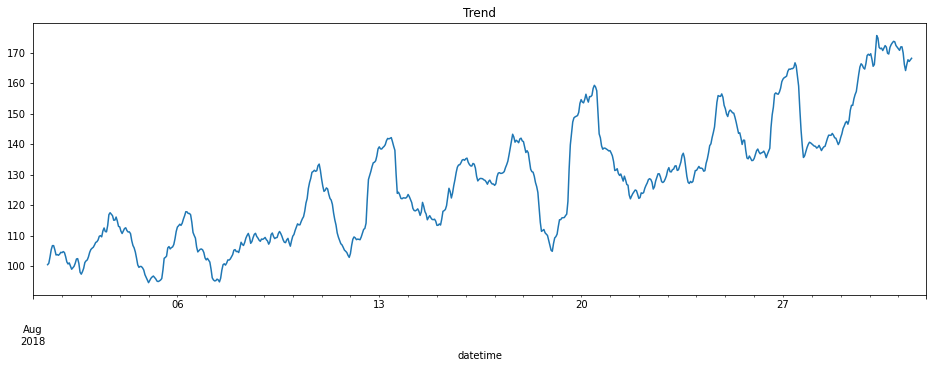

In [10]:
plt.figure(figsize=(16, 5))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.show()

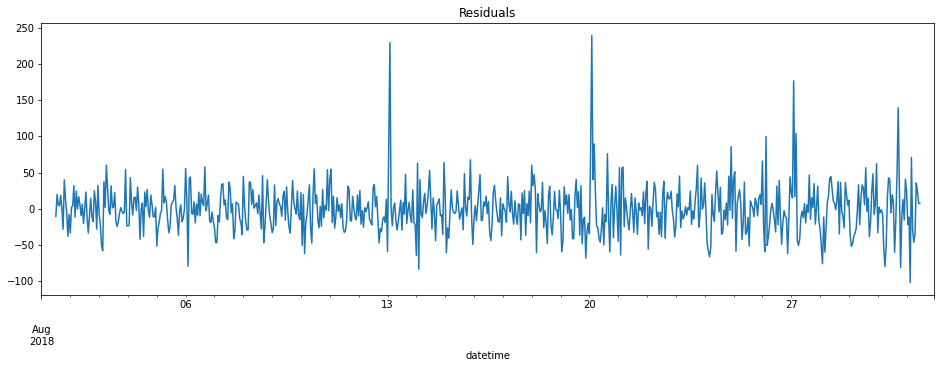

In [11]:
plt.figure(figsize=(16, 5))
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.show()

На протяжении всего периода:

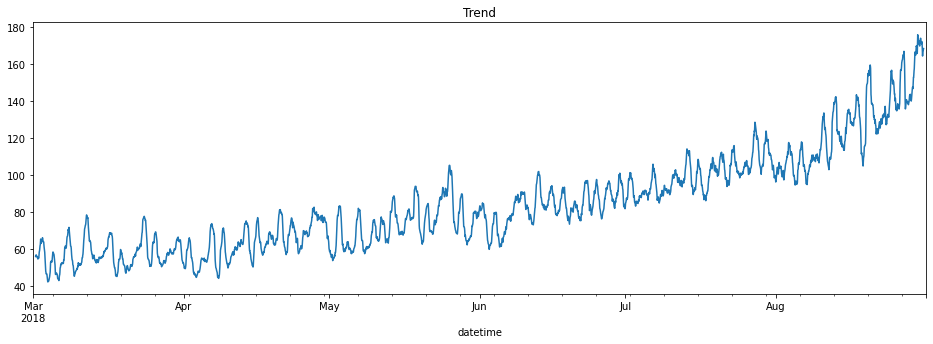

In [12]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(16, 5))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.show()

- Видим наличие тренда, а так же периодические колебания спроса (обусловленные временем суток).
- так же видим, что сравнительно равномерный шум имеет выбросы каждые 7 дней - вероятно это всплески спроса связанные с выходными днями.

Посмотрим на другом масштабе:

In [13]:
data_day = data.resample('1D').sum()
decomposed = seasonal_decompose(data_day['2018-08':'2018-09'])

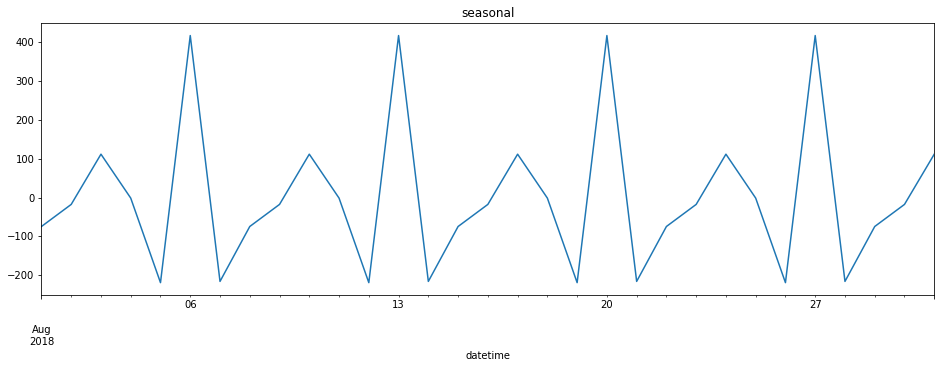

In [14]:
plt.figure(figsize=(16, 5))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('seasonal')
plt.show()

 - дни пикового спроса - каждое воскресенье.

## Обучение

Сделаем таблицу для результатов: 

In [15]:
models = pd.DataFrame({'Модель':[]
                       ,'Параметры доп признаков':[]
                       ,'Параметры модели':[]
                       ,'RMSE на тренировочной выборке':[]
                       ,'RMSE тестовой выборке':[]})


### Baseline

В качестве базового прогноза будем использовать предсказание предыдущим значением:

In [16]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [17]:
base_prediction = test.shift()
base_prediction.iloc[0] = train.iloc[-1]
rmse = round(mean_squared_error(test,base_prediction)**0.5,2)
print('RMSE базового прогноза (прогноз предыдущим значением):', rmse)

RMSE базового прогноза (прогноз предыдущим значением): 58.86


In [18]:
new_model = {'Модель':'Прогноз предыдущим значением'
             ,'Параметры доп признаков':''
             ,'Параметры модели':''
             ,'RMSE на тренировочной выборке':''
             ,'RMSE на валидационной выборке':rmse}

models = models.append(new_model, ignore_index=True)

In [19]:
models.head()

,Модель,Параметры доп признаков,Параметры модели,RMSE на тренировочной выборке,RMSE тестовой выборке
0,Прогноз предыдущим значением,,,,58.86


Далее, для обучения и валидации моделей, подбора параметров будем использовать только train выборку:

In [20]:
taxi_train = train.copy()

### Добавление обучающих признаков

Сделаем функцию для создания дополнительных признаков. Добавим: время (час), день недели, отстающие значения (со сдвигами от 1 часа до максимального значения, которое подберем экспериментально) и скользящее среднее: 

In [21]:
def add_features(data, max_lag, rolling_mean_size):
    added_data = data.copy()
    added_data['hour'] = added_data.index.hour
    added_data['dayofweek'] = added_data.index.dayofweek

    for lag in range(1, max_lag + 1):
        added_data['lag_{}'.format(lag)] = added_data['num_orders'].shift(lag)

    added_data['rolling_mean'] = added_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return added_data

### Линейная регрессия

Подберем оптимальный набор дополнительных признаков обучая модель "линейная регрессия" на разных наборах:

In [22]:
best_max_lag = 0
best_rolling_mean_size = 0
best_rmse = 100
best_rmse_train = 100

for lag in range(10,101,4):
    for roll_min_size in range(4,49,4):
        added_data = add_features(taxi_train, lag, roll_min_size)
        
        train, valid = train_test_split(added_data, shuffle=False, test_size=0.1)
        train = train.dropna()
        X_train = train.drop('num_orders', axis=1)
        y_train = train['num_orders']
        X_valid = valid.drop('num_orders', axis=1)
        y_valid = valid['num_orders']
        
        model = LinearRegression()
        model.fit(X_train,y_train)
        pred_valid = model.predict(X_valid)
        
        rmse = mean_squared_error(pred_valid,y_valid)**0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_rolling_mean_size = roll_min_size
            best_max_lag = lag
            lr_best_model = model
            pred_train = model.predict(X_train)
            best_rmse_train = mean_squared_error(pred_train,y_train)**0.5
        
        
print("RMSE на тренировочной выборке: ", round(best_rmse_train,2))
print("Лучший RMSE на валидационной выборке: ", round(best_rmse,2))
print('')
print("Лучший максимальный сдвиг: ", best_max_lag)
print("Лучший размер скользящего среднего : ", best_rolling_mean_size)

RMSE на тренировочной выборке:  21.24
Лучший RMSE на валидационной выборке:  29.82

Лучший максимальный сдвиг:  98
Лучший размер скользящего среднего :  36


In [23]:
new_model = {'Модель':'LinearRegression'
             ,'Параметры доп признаков':'Макс сдвиг: {}, Размер скользящего среднего: {}'.format(best_max_lag,best_rolling_mean_size)
             ,'Параметры модели':''
             ,'RMSE на тренировочной выборке':round(best_rmse_train,2)
             ,'RMSE на валидационной выборке':round(best_rmse,2)}

models = models.append(new_model, ignore_index=True)

### Lasso

In [24]:
best_max_lag = 0
best_rolling_mean_size = 0

best_rmse = 100
rmse_train = 100

alpha = 0.8

for lag in range(10,101,4):
    for roll_mean_size in range(4,49,4):
        added_data = add_features(taxi_train, lag, roll_min_size)
        
        train, valid = train_test_split(added_data, shuffle=False, test_size=0.1)
        train = train.dropna()
        X_train = train.drop('num_orders', axis=1)
        y_train = train['num_orders']
        X_valid = valid.drop('num_orders', axis=1)
        y_valid = valid['num_orders']
        
        model = Lasso(alpha=alpha)
        model.fit(X_train,y_train)
        pred_valid = model.predict(X_valid)
        
        rmse = mean_squared_error(pred_valid,y_valid)**0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_rolling_mean_size = roll_mean_size
            best_max_lag = lag
            lasso_best_model = model
            pred_train = model.predict(X_train)
            rmse_train = mean_squared_error(pred_train,y_train)**0.5
        
        
print("RMSE на тренировочной выборке: ", round(best_rmse_train,2))
print("Лучший RMSE на валидационной выборке: ", round(best_rmse,2))
print('')
print("Лучший максимальный сдвиг: ", best_max_lag)
print("Лучший размер скользящего среднего : ", best_rolling_mean_size)

RMSE на тренировочной выборке:  21.24
Лучший RMSE на валидационной выборке:  29.8

Лучший максимальный сдвиг:  98
Лучший размер скользящего среднего :  4


In [25]:
new_model = {'Модель':'Lasso'
             ,'Параметры доп признаков':'Макс сдвиг: {}, Размер скользящего среднего: {}'.format(best_max_lag,best_rolling_mean_size)
             ,'Параметры модели':'alpha={}'.format(alpha)
             ,'RMSE на тренировочной выборке':round(rmse_train,2)
             ,'RMSE на валидационной выборке':round(best_rmse,2)}

models = models.append(new_model, ignore_index=True)

### RandomForestRegressor

In [26]:
best_max_lag = 0
best_rolling_mean_size = 48 

best_n_estimators = 0 
best_depth = 0 

best_rmse = 100
rmse_train = 100

for lag in range(60,101,10):
    for est in range(60,91,10):
        for depth in range(7,10):
            added_data = add_features(taxi_train, lag, best_rolling_mean_size)
            train, valid = train_test_split(added_data, shuffle=False, test_size=0.1)
            train = train.dropna()
            X_train = train.drop('num_orders', axis=1)
            y_train = train['num_orders']
            X_valid = valid.drop('num_orders', axis=1)
            y_valid = valid['num_orders']
        
            model = RandomForestRegressor(n_estimators=est, max_depth=depth, n_jobs=-1)
            model.fit(X_train,y_train)
            pred_valid = model.predict(X_valid)
        
            rmse = mean_squared_error(pred_valid,y_valid)**0.5
            if rmse < best_rmse:
                best_rmse = rmse
                best_max_lag = lag
                best_n_estimators = est
                best_depth = depth
                rf_best_model = model
                
                pred_train = model.predict(X_train)
                rmse_train = round(mean_squared_error(pred_train,y_train)**0.5,2)
            
        
        
print("RMSE на тренировочной выборке: ", rmse_train)
print("Лучший RMSE на валидационной выборке: ", round(best_rmse,2))
print("Лучший максимальный сдвиг: ", best_max_lag)
print("Лучший максимальная глубина деревьев: ", best_depth)
print("Лучший n-estimators: ", best_n_estimators)

RMSE на тренировочной выборке:  13.52
Лучший RMSE на валидационной выборке:  31.07
Лучший максимальный сдвиг:  90
Лучший максимальная глубина деревьев:  9
Лучший n-estimators:  80


In [27]:
new_model = {'Модель':'RandomForestRegressor'
             ,'Параметры доп признаков':'Макс сдвиг: {}, Размер скользящего среднего: {}'.format(best_max_lag,best_rolling_mean_size)
             ,'Параметры модели':'max_depth={}, n-estimators={}'.format(best_depth,best_n_estimators)
             ,'RMSE на тренировочной выборке':round(rmse_train,2)
             ,'RMSE на валидационной выборке':round(best_rmse,2)}

models = models.append(new_model, ignore_index=True)

### LGBMRegressor

In [28]:
best_max_lag = 0
best_rolling_mean_size = 0
best_rate = 0

best_rmse = 100
rmse_train = 100

learning_rates = [0.05, 0.2]

for lag in range(60,101,5):
    for roll_mean_size in range(20,33,4):
        for rate in learning_rates:
            added_data = add_features(taxi_train, lag, roll_mean_size)
            train, valid = train_test_split(added_data, shuffle=False, test_size=0.1)
            train = train.dropna()
            X_train = train.drop('num_orders', axis=1)
            y_train = train['num_orders']
            X_valid = valid.drop('num_orders', axis=1)
            y_valid = valid['num_orders']
        
            model = LGBMRegressor(max_depth=50,learning_rate=rate, n_jobs=4)
            model.fit(X_train,y_train)
            pred_valid = model.predict(X_valid)
        
            rmse = mean_squared_error(pred_valid,y_valid)**0.5
            if rmse < best_rmse:
                best_rmse = rmse
                best_rolling_mean_size = roll_mean_size
                best_max_lag = lag
                best_rate = rate
            
                LGBM_best_model = model
                
                pred_train = model.predict(X_train)
                rmse_train = round(mean_squared_error(pred_train,y_train)**0.5,2)
        

print("RMSE на тренировочной выборке: ", rmse_train)
print("Лучший RMSE на валидационной выборке: ", round(best_rmse,2))
print("Лучший максимальный сдвиг: ", best_max_lag)
print("Лучший размер скользящего среднего: ", best_rolling_mean_size)
print('Лучший learning rate: ',best_rate)

RMSE на тренировочной выборке:  4.85
Лучший RMSE на валидационной выборке:  29.61
Лучший максимальный сдвиг:  85
Лучший размер скользящего среднего:  24
Лучший learning rate:  0.2


In [29]:
new_model = {'Модель':'LGBMRegressor'
             ,'Параметры доп признаков':'Макс сдвиг: {}, Размер скользящего среднего: {}'.format(best_max_lag,best_rolling_mean_size)
             ,'Параметры модели':'learning rate={}'.format(best_rate)
             ,'RMSE на тренировочной выборке':round(rmse_train,2)
             ,'RMSE на валидационной выборке':round(best_rmse,2)}

models = models.append(new_model, ignore_index=True)

## Тестирование

In [30]:
models.head()

,Модель,Параметры доп признаков,Параметры модели,RMSE на тренировочной выборке,RMSE тестовой выборке,RMSE на валидационной выборке
0,Прогноз предыдущим значением,,,,58.86,NaN
1,LinearRegression,"Макс сдвиг: 98, Размер скользящего среднего: 36",,21.24,NaN,29.82
2,Lasso,"Макс сдвиг: 98, Размер скользящего среднего: 4",alpha=0.8,21.25,NaN,29.80
3,RandomForestRegressor,"Макс сдвиг: 90, Размер скользящего среднего: 48","max_depth=9, n-estimators=80",13.52,NaN,31.07
4,LGBMRegressor,"Макс сдвиг: 85, Размер скользящего среднего: 24",learning rate=0.2,4.85,NaN,29.61


Сделаем прогноз на тестовой выборке, при оптимальном наборе дополнительных признаков, с помощью лучшей из моделей (LGBMRegressor):

Для этого мы переходим заново к полному набору данных, добавляем признаки и заново разбиваем на train и test выборки. Т.к. мы используем параметр shuffle=False, то в тестовыую выборку не попадают данные использовавшиеся при подборе оптимальных параметров, а та часть данных которая использовалась при валидации, теперь будет использована как часть тренировочной выборки для повторного обучения модели с ранее подобранными оптимальными параметрами:

In [31]:
added_data = add_features(data, 85, 24)
train, test = train_test_split(added_data, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']
        
model = model = LGBMRegressor(max_depth=50,learning_rate=0.2, n_jobs=-1)
model.fit(X_train,y_train)
pred_test = model.predict(X_test)
        
rmse = round(mean_squared_error(pred_test,y_test)**0.5,2)
print('rmse на тестовой выборке: ',rmse)

rmse на тестовой выборке:  39.27


Сравним графики предсказанных значений с реальными:

In [32]:
predicted_test = pd.Series(pred_test, index = y_test.index, name='orders_pred')
target_pred = pd.concat([y_test,predicted_test],axis=1)

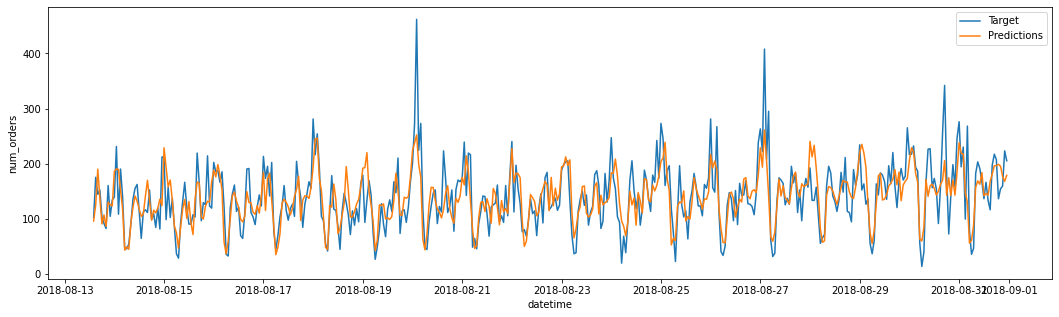

In [33]:
plt.figure(figsize=(18,5))
sns.lineplot(x=target_pred.index, y=target_pred['num_orders'], label='Target')
sns.lineplot(x=target_pred.index, y=target_pred['orders_pred'], label='Predictions')
plt.show()

Более детально:

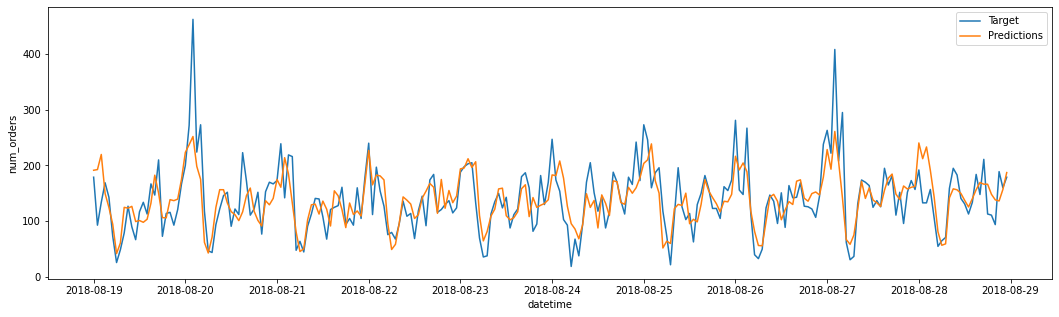

In [34]:
target_pred = target_pred['2018-08-19':'2018-08-28']
plt.figure(figsize=(18,5))
sns.lineplot(x=target_pred.index, y=target_pred['num_orders'], label='Target')
sns.lineplot(x=target_pred.index, y=target_pred['orders_pred'], label='Predictions')
plt.show()

 - наихудшие прогнозы приходятся на пики спроса. 

## Вывод

- Все модели показали результат лучше чем baseline (предсказание предыдущим значением).
- Лучшие прогнозы получены на модели LGBMRegressor с результатом по RMSE: 39.27 (на 33% лучше, чем результат baseline - 58.87)
- Хуже всего удается прогнозировать пики спроса, точнее: резкие изменения спроса.